In [1]:
!pip install -q condacolab

import condacolab
condacolab.install()

# install ngspice packages, including executables & master package
!conda install -c conda-forge ngspice-exe  
!conda install -c conda-forge ngspice      
!conda install -c conda-forge ngspice-lib

!pip install PySpice

!pyspice-post-installation --check-install


RuntimeError: This module must ONLY run as part of a Colab notebook!

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
#import PySpice.Logging.Logging as Logging
#logger = Logging.setup_logging()

from PySpice.Spice.Netlist import Circuit
#from PySpice.Unit import *

In [457]:
#################
# 1. Параметры рабочей точки ВЧ разряда
#################
Vm = 100                                # Амплитуда ВЧ источника [V]
f0 = 13.56e+6                           # Частота ВЧ источника [Гц]
p0 = 0.66                               # Давление газа [Па]
T0 = 300                                # Температура буферного газа [К]
ne = 1.25e+15                           # Начальное приближение плотности электронов [м^-3]
Te = 4.75                               # Температура электронов [эВ]
l_B = 5.7e-2                            # Толщина bulk плазмы [м]
Km = 1e-13                              # Коэффициент электронно-нейтральных столкновений [м^3*с^-1]
Ae = 0.01                               # Площадь нагруженного электрода [м^2]
Ag = 0.03                               # Площадь заземленного электрода [м^2]

#################
# 2. Физические константы
#################
qe = 1.6e-19                            # Заряд электрона [Кл]
me = 9.11e-31                           # Масса электрона [кг]
Mi=6.6335209e-26-9.1093837e-31          # Масса иона Ar [кг]
#k_B = 1.38e-23                          # Постоянная Больцмана [Дж/К]
eps_0 = 8.85e-12                        # Диэлектрическая постоянная [Ф/м]

#################
# 3. Вычисляемые величины
#################
ng = p0/(k_B*T0)                        # Концентрация буферного газа [м^-3]
nu_el_netr = Km*ng                      # Частота электронно-нейтральных столкновений [c^-1]
Vp = Ae*l_B                             # Объем плазменного столба
v_Bomh = math.sqrt(qe*Te/Mi)            # Бомовская скорость ионов
v_midd_e = math.sqrt(8*qe*Te/(3.14*me)) # Средняя тепловая скорость электронов
nu_eff = nu_el_netr+(v_midd_e/l_B)      # Эффективная частота электронно-нейтральных столкновений [c^-1]
Ie01 = qe*ne*v_midd_e*Ae                # Амплитуда электронного тока у управляющего электрода [А]
Ie02 = qe*ne*v_midd_e*Ag                # Амплитуда электронного тока у заземленного электрода [А]
alpha = -1/Te                           # Коэффициент показателя экспоненты электронного тока
Iion1 = qe*ne*v_Bomh*Ae                 # Полный ионный ток на управляющий электрод [А]
Iion2 = qe*ne*v_Bomh*Ag                 # Полный ионный ток на заземленный электрод [А]
CCs1 = (qe*ne*eps_0*Ae**2)/2            # Коэффициент при емкости слоя управляющего электрода
CCs2 = (qe*ne*eps_0*Ag**2)/2            # Коэффициент при емкости слоя заземленного электрода
Lp = l_B*me/(qe**2*ne*Ae)               # Индуктивность bulk плазмы [Гн]
Rp = nu_eff*Lp                          # Сопротивление bulk плазмы [Ом]
Tf=1/f0                                 # Период ВЧ поля [с]

#################
# 4. Настройки анализа Ngspice
#################
num_periods_sim=500                     # Количество периодов ВЧ поля, которое надо просчитать
sim_periods_div=100                     # Количество точек результата на период
tmax_sim = Tf*num_periods_sim           # Сколько времени просчитывать в Ngspice
tmin_sim = Tf*(num_periods_sim-5)       # От какого времени делать вывод
timestep_output = Tf/sim_periods_div    # Шаг, с которым будет вывод

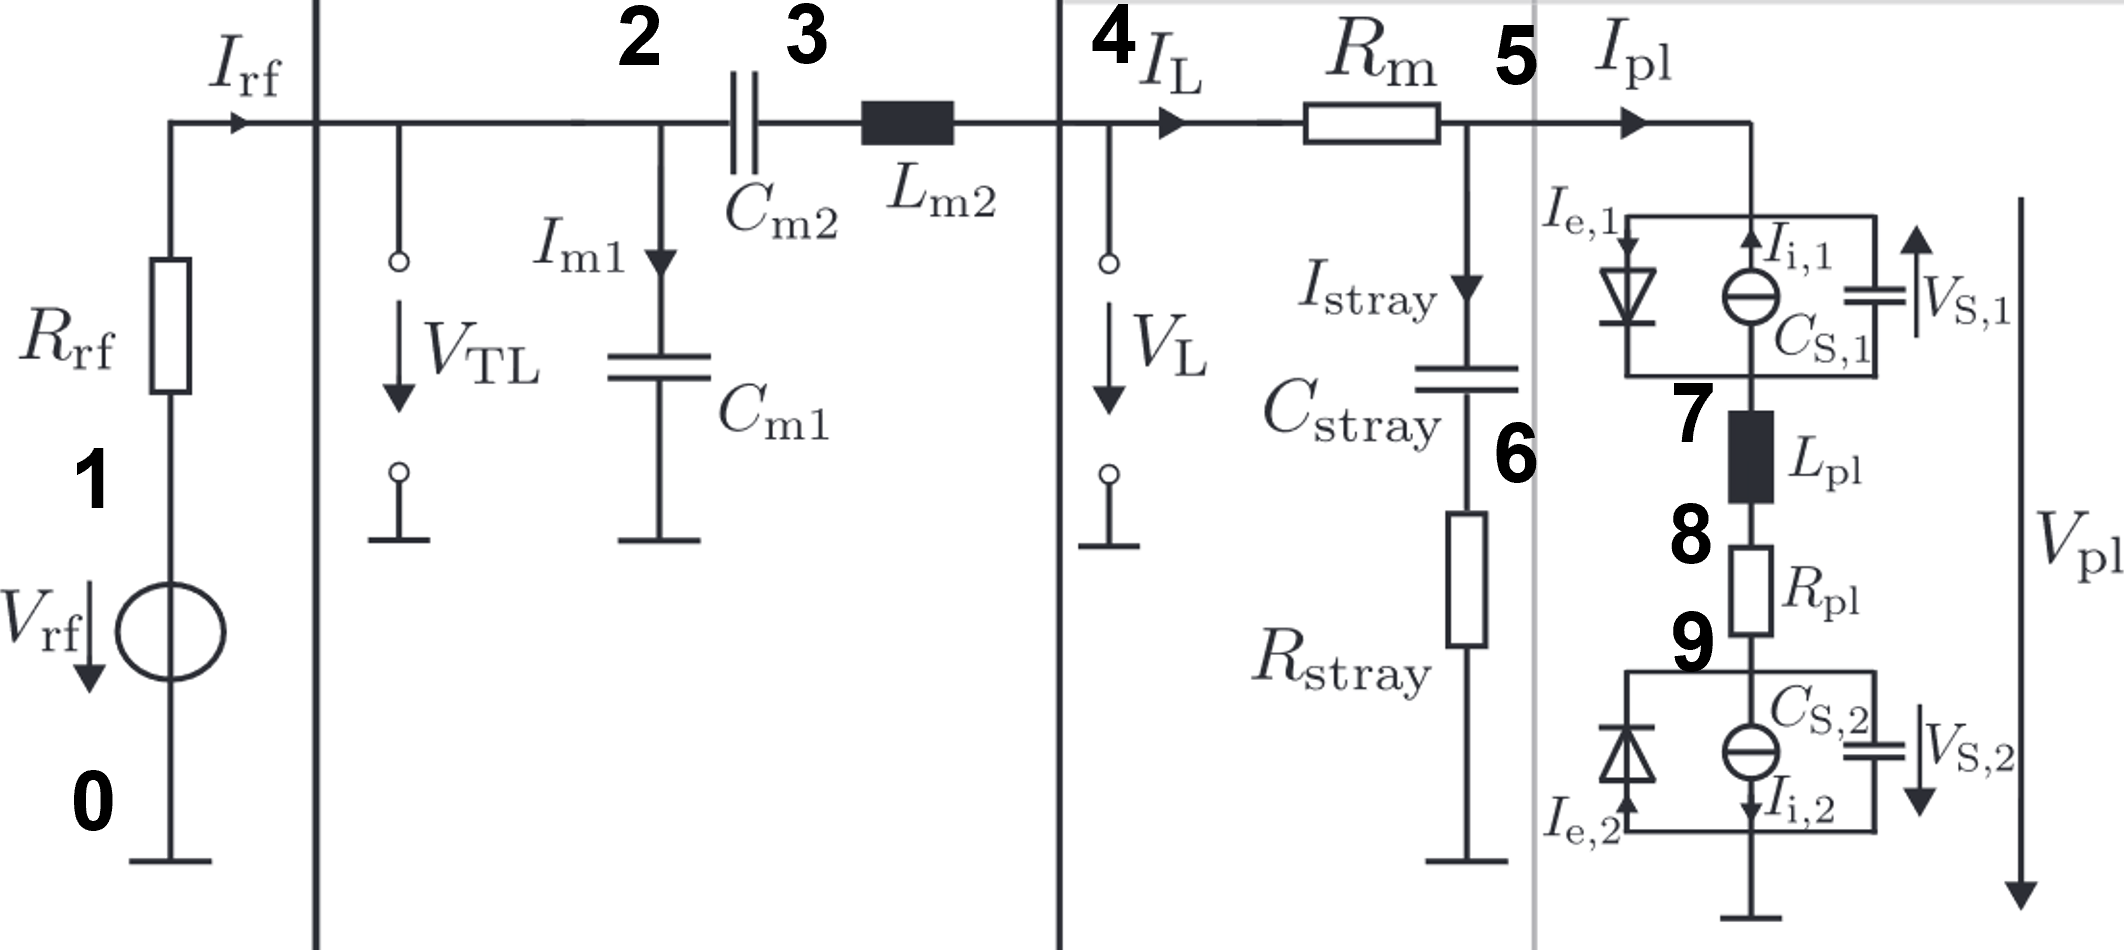

In [458]:
circuit = Circuit('RF discharge impedance')

val_R_rf = 50
val_C_m1 = 1550e-12
val_C_m2 = 175e-12
val_L_m2 = 1500e-9
val_R_m = 0.5
val_C_stray = 200e-12
val_R_stray = 0.5

circuit.SinusoidalVoltageSource('V0', 1, 0, amplitude = Vm, frequency = f0)
circuit.R('Rrf', 1, 2, val_R_rf)
circuit.C('Cm1', 2, 0, val_C_m1)
circuit.C('Cm2', 2, 3, val_C_m2)
circuit.L('Lm2', 3, 4, val_L_m2)
circuit.R('Rm', 4, 5, val_R_m)
circuit.C('Cstray', 5, 6, val_C_stray)
circuit.R('Rstray', 6, 0, val_R_stray)
circuit.BehavioralSource('Be_e', 5, 7, current_expression=f'v(7,5) > 0 ? {Ie01}*exp({alpha}*v(7,5)) : 1e-12')
circuit.CurrentSource('Bi_e', 7, 5, Iion1)
circuit.BehavioralCapacitor('Cs1', 7, 5, capacitance_expression=f'C=\'sqrt({CCs1}/abs(v(7,5)))\'')
circuit.L('L_p', 7, 8, Lp)
circuit.R('R_p', 8, 9, Rp)
circuit.BehavioralSource('Be_g', 10, 9, current_expression=f'v(9,10) > 0 ? {Ie02}*exp({alpha}*v(9,10)) : 1e-12')
circuit.CurrentSource('Bi_g', 9, 10, Iion2)
circuit.BehavioralCapacitor('Cs2', 9, 10, capacitance_expression=f'C=\'sqrt({CCs2}/abs(v(9,10)))\'')
circuit.VoltageSource('Viz', 10, 0, 0)

#print(circuit) # Можно напечатать получившийся netlist для проверки

VoltageSource VViz

In [459]:
simulator = circuit.simulator()
simulator._initial_condition={'v(5)':1e-10, 'v(9)':1e-10}
#simulator.initial_condition['v(5)']=1e-10

#print(simulator) # Можно напечатать .IC для проверки
analysis = simulator.transient(step_time=Tf/100, end_time=tmax_sim)

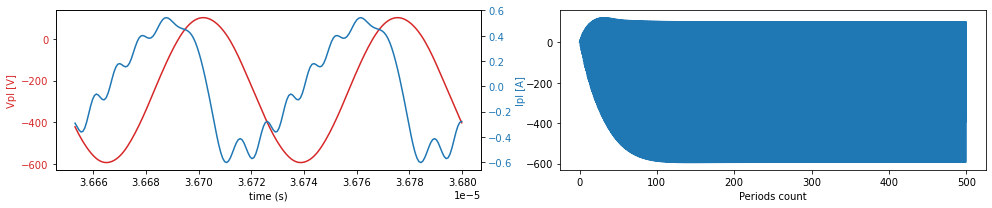

In [460]:
time_data = np.array(analysis.time)

v5_data = np.array(analysis['5'])                                 # Vpl
v9_data = (np.array(analysis['8'])-np.array(analysis['9']))/Rp    # Ipl


fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))

color = 'tab:red'
ax1[0].set_xlabel('time (s)')
ax1[0].set_ylabel('Vpl [V]', color=color)
ax1[0].plot(time_data[-3*sim_periods_div:-1*sim_periods_div], v5_data[-3*sim_periods_div:-1*sim_periods_div], color=color)  # Показываем два _предпоследних_ периода, т.к.
ax1[0].tick_params(axis='y', labelcolor=color)
ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Ipl [A]', color=color)  # we already handled the x-label with ax1
ax2.plot(time_data[-3*sim_periods_div:-1*sim_periods_div], v9_data[-3*sim_periods_div:-1*sim_periods_div], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1[1].plot(time_data/Tf, v5_data)
_=ax1[1].set_xlabel('Periods count')

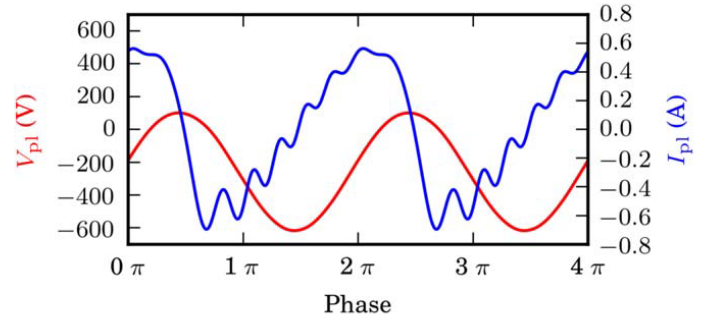

In [461]:
a = np.diff(time_data)
np.set_printoptions(threshold=100)
print(a)

[7.37463127e-12 6.19508103e-13 1.23901621e-12 ... 7.37463127e-10
 7.37463127e-10 3.13738585e-10]


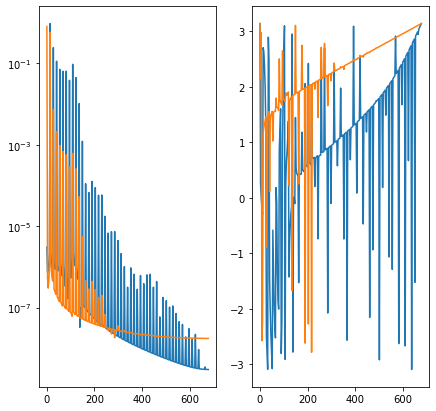

In [462]:
from scipy.fft import rfft, rfftfreq

first_steady_period = 260
num_periods_for_spectra = 5

N_start = sim_periods_div*first_steady_period
N_end = sim_periods_div*(first_steady_period+num_periods_for_spectra)
i_spectra = rfft(v9_data[N_start:N_end])
v_spectra = rfft(v5_data[N_start:N_end])

freqs = rfftfreq(v9_data[N_start:N_end].size, d=Tf/sim_periods_div)
freqsMHz = freqs/1e6
#print(freqs)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

#i_plot = i_spectra[0:500]
i_plot = i_spectra
i_norm = np.linalg.norm(i_plot)
i_normalized = abs(i_plot)/i_norm
axs[0].semilogy(freqsMHz, i_normalized)

#v_plot = v_spectra[0:500]
v_plot = v_spectra
v_norm = np.linalg.norm(v_plot)
v_normalized = abs(v_plot)/v_norm

axs[0].semilogy(freqsMHz, v_normalized)
#axs[0].xlabel('Frequency [MHz]')

i_phase = np.angle(i_plot)
v_phase = np.angle(v_plot)

axs[1].plot(freqsMHz, i_phase)
axs[1].plot(freqsMHz, v_phase)
#axs[1].xlabel('Frequency [MHz]')

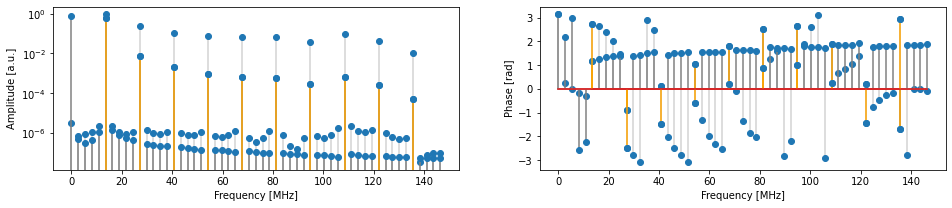

In [463]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))

nHarm = 10

idxHarm = (nHarm+1)*num_periods_for_spectra

freqsReducedHarm = freqsMHz[0:idxHarm]
i_reducedHarm = i_normalized[0:idxHarm]
v_reducedHarm = v_normalized[0:idxHarm]

i_phaseReducedHarm = i_phase[0:idxHarm]
v_phaseReducedHarm = v_phase[0:idxHarm]

idxrange = np.arange(start=num_periods_for_spectra, stop=(nHarm+1)*num_periods_for_spectra, step=num_periods_for_spectra)

axs[0].stem(freqsReducedHarm, i_reducedHarm, linefmt='lightgrey')
axs[0].stem(freqsReducedHarm, v_reducedHarm, linefmt='grey')
axs[0].stem(freqsReducedHarm[idxrange], v_reducedHarm[idxrange], linefmt='orange')
axs[0].set_yscale('log')
axs[0].set_xlabel('Frequency [MHz]')
axs[0].set_ylabel('Amplitude [a.u.]')

axs[1].stem(freqsReducedHarm, i_phase[0:idxHarm], linefmt='lightgrey')
axs[1].stem(freqsReducedHarm, v_phase[0:idxHarm], linefmt='grey')
axs[1].stem(freqsReducedHarm[idxrange], v_phaseReducedHarm[idxrange], linefmt='orange')
axs[1].stem(freqsReducedHarm[idxrange], i_phaseReducedHarm[idxrange], linefmt='orange')
axs[1].set_ylabel('Phase [rad]')
_=axs[1].set_xlabel('Frequency [MHz]')

In [464]:
print(i_reducedHarm.size)
idxrange = np.arange(start=num_periods_for_spectra, stop=(nHarm+1)*num_periods_for_spectra, step=num_periods_for_spectra)
print(idxrange)
print(i_reducedHarm[idxrange])

55
[ 5 10 15 20 25 30 35 40 45 50]
[0.94981431 0.24340815 0.11291271 0.07113215 0.06395501 0.06429075
 0.03833343 0.09486393 0.04467964 0.01030639]


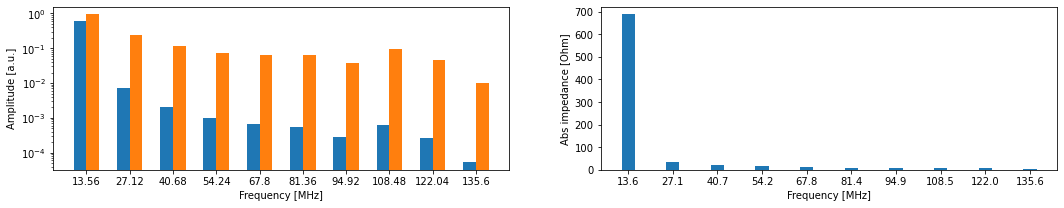

In [465]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))

barWidth = 4

br1 = freqsReducedHarm[idxrange]
br2 = [x + barWidth for x in br1]       

axs[0].bar(br1, v_reducedHarm[idxrange], width = barWidth)
axs[0].bar(br2, i_reducedHarm[idxrange], width = barWidth)
axs[0].set_yscale('log')
axs[0].set_ylabel('Amplitude [a.u.]')
axs[0].set_xlabel('Frequency [MHz]')

_ = axs[0].set_xticks([x + 0.5*barWidth for x in br1], np.round(br1, 2))

z_norm = v_norm/i_norm

axs[1].bar(br1, z_norm*v_reducedHarm[idxrange]/i_reducedHarm[idxrange], width = barWidth)
_ = axs[1].set_xticks(np.round(br1, 2))
axs[1].set_ylabel('Abs impedance [Ohm]')
_ = axs[1].set_xlabel('Frequency [MHz]')

Ppl = 3.651726187809497 [W]
_Vs1 = -303.1774965160697 [V]
_Vs2 = 62.305796675147874 [V]
PRrf = 34.594534082438116 [W]


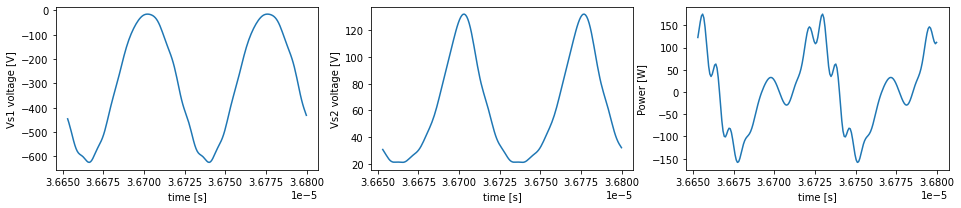

In [466]:
from scipy.integrate import trapezoid

#power_norm = v_norm/i_norm
#print(power_norm)

num_perods_for_integration = 30  # Определить минимально необходимое количество периодов на просчитывать, при котором результат интеграла сходится.
                                # Это и будет критерий наступления установившегося режима

Vpl_data = v5_data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]
Ipl_data = v9_data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]
t_data = time_data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]

#print(I_data.size, V_data.size)

Ppl_data = np.multiply(Vpl_data, Ipl_data)

Ppl = 1/(num_perods_for_integration*Tf) * trapezoid(x=t_data, y=Ppl_data)

print(f'Ppl = {Ppl} [W]')

vs1_raw_data = np.array(analysis['5']) - np.array(analysis['7'])
vs2_raw_data = np.array(analysis['9']) - np.array(analysis['10'])
V_R_rf_raw_data = np.array(analysis['2']) - np.array(analysis['1'])


vs1_data = vs1_raw_data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]
vs2_data = vs2_raw_data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]
V_R_rf_data = V_R_rf_raw_data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]

P_R_rf_data = np.multiply(V_R_rf_data, V_R_rf_data)/val_R_rf

#print(vs1_data)

_Vs1 = 1/(num_perods_for_integration*Tf) * trapezoid(x=t_data, y=vs1_data)
_Vs2 = 1/(num_perods_for_integration*Tf) * trapezoid(x=t_data, y=vs2_data)
P_R_rf = 1/(num_perods_for_integration*Tf) * trapezoid(x=t_data, y=P_R_rf_data)

print(f'_Vs1 = {_Vs1} [V]')
print(f'_Vs2 = {_Vs2} [V]')

print(f'PRrf = {P_R_rf} [W]')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 3))

axs[0].plot(t_data[-2*sim_periods_div:], vs1_data[-2*sim_periods_div:])
axs[0].set_ylabel('Vs1 voltage [V]')
axs[0].set_xlabel('time [s]')

axs[1].plot(t_data[-2*sim_periods_div:], vs2_data[-2*sim_periods_div:])
axs[1].set_ylabel('Vs2 voltage [V]')
axs[1].set_xlabel('time [s]')

axs[2].plot(t_data[-2*sim_periods_div:], Ppl_data[-2*sim_periods_div:])
axs[2].set_ylabel('Power [W]')
_=axs[2].set_xlabel('time [s]')


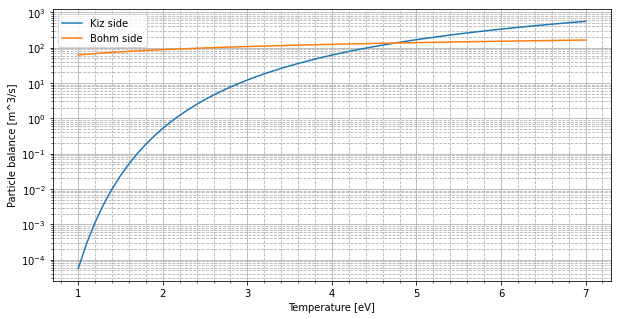

In [467]:
##############
# Определение Te
##############

def Kiz_novect(Te):
#    res = np.multiply(np.multiply(2.34e-14, pow(Te, 0.59)), np.exp(-17.44/Te))
    res = 2.34e-14*Te**0.59*np.exp(-17.44/Te)
#    res = 2.9e-14*Te**0.50*np.exp(-17.8/Te)
    return(res)
Kiz = np.vectorize(Kiz_novect, otypes=[float])

def u_Bohm_novect(Te):
    res = np.sqrt(qe*Te/Mi)
    return res
u_Bohm = np.vectorize(u_Bohm_novect, otypes=[float])

en_range = np.arange(1, 7.1, 0.1)
val_Kiz_side = Vp*ng*Kiz(en_range)
val_Bohm_side = (Ae + Ag)*u_Bohm(en_range)

#print(val_Kiz)
#print(Kiz_vect(3))
#print(en_range)
#print(f'Ae + Ag = {Ae + Ag}')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
minor_ticks = np.arange(0, 101, 4)
ax.set_xticks(minor_ticks, minor=True)
plt.plot(en_range, val_Kiz_side, label='Kiz side')
plt.plot(en_range, val_Bohm_side, label='Bohm side')
plt.grid(which='minor', linestyle='--')
plt.grid(which='major', linestyle='-')
plt.minorticks_on()
#plt.plot(en_range, val_Bohm_side-val_Kiz_side, label='difference')
plt.yscale('log')
plt.xlabel('Temperature [eV]')
plt.ylabel('Particle balance [m^3/s]')
plt.legend()
plt.show()

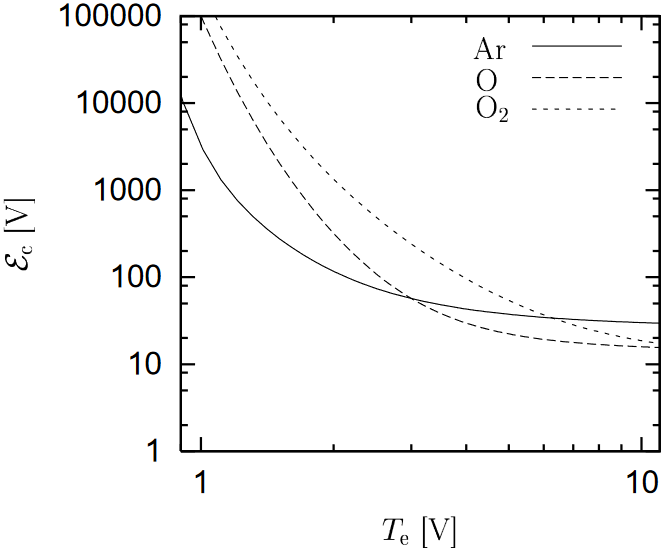

Te = 4.750 [eV]
fE = 0.250 [a.u.]
fG = 0.750 [a.u.]
eps_c(Te)=1.849e+01
eps_e = 9.500e+00
fE*np.abs(_Vs1)=7.579e+01
fG*np.abs(_Vs2)=4.673e+01
Te/2=2.375
ng=1.594e+20
Kiz(Te)=1.493e-15
Ppl=3.652e+00  [W]
Pguess=4.147e+00  [W]
ne_new=1.101e+15
|ne_new - ne|=1.493e+14


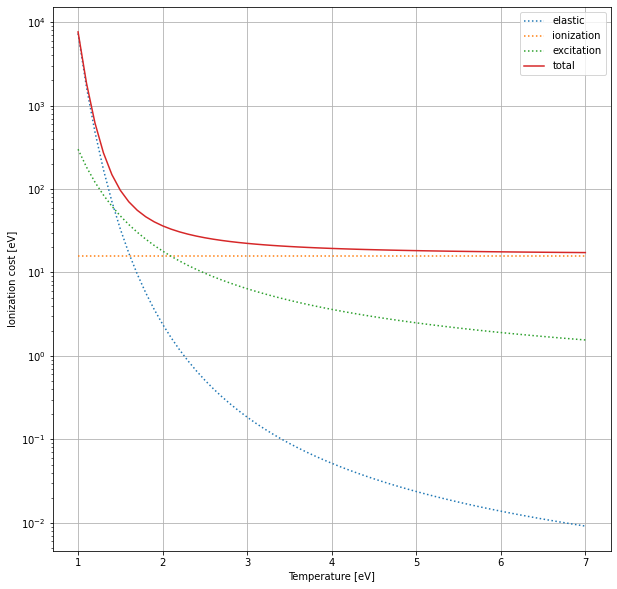

In [472]:
##############
# Определение n
##############

def Kex_novec(Te):
    res = 5.02e-15*np.exp(-12.64/Te)   # 3p1 11.5 eV
    return(res)
Kex = np.vectorize(Kex_novec, otypes=[float])

def Kel_novec(Te):
    lnkel = -31.3879 + 1.6090*np.log(Te) + 0.0618*np.log(Te)**2 - 0.1171*np.log(Te)**3
    #print(f'lnkel = {lnkel}')
    res = np.exp(lnkel)
#    res = lnkel
    return(res)
Kel = np.vectorize(Kel_novec, otypes=[float])

eps_ex = 11.5
eps_el = 3*me*Te/Mi

eps_iz = 15.76 # Энергия ионизации Ar [eV]

def eps_c_novec(Te):
#    res = eps_iz + (Kex(Te)*eps_ex + Kel(Te)*eps_el)/Kiz(Te)
    res = eps_iz + (Kel(Te)*eps_el + Kex(Te)*eps_ex)/Kiz(Te)
    return res
eps_c = np.vectorize(eps_c_novec, otypes=[float])


#print(en_range)
eps_c_data = eps_c(en_range)

plt.figure(figsize=(10, 10))
plt.plot(en_range, (Kel(en_range)*eps_el)/Kiz(en_range), linestyle=':', label = 'elastic')
plt.plot(en_range, eps_iz*np.ones(en_range.size), linestyle=':', label = 'ionization')
plt.plot(en_range, (Kex(en_range)*eps_ex)/Kiz(en_range), linestyle=':', label = 'excitation')
plt.plot(en_range, eps_c(en_range), label = 'total')
plt.yscale('log')
plt.xlabel('Temperature [eV]')
plt.ylabel('Ionization cost [eV]')
plt.legend()
plt.grid()

#########

print(f'Te = {Te:.3f} [eV]')

fE = Ae/(Ae + Ag)
print(f'fE = {fE:.3f} [a.u.]')

fG = Ag/(Ae + Ag)
print(f'fG = {fG:.3f} [a.u.]')

eps_e = 2*Te

print(f'eps_c(Te)={eps_c(Te):.3e}')
print(f'eps_e = {eps_e:.3e}')
print(f'fE*np.abs(_Vs1)={fE*np.abs(_Vs1):.3e}')
print(f'fG*np.abs(_Vs2)={fG*np.abs(_Vs2):.3e}')
print(f'Te/2={Te/2:.3f}')

print(f'ng={ng:.3e}')
print(f'Kiz(Te)={Kiz(Te):.3e}')

Pguess = ne*Vp*ng*Kiz(Te)*(eps_c(Te) + eps_e + fE*np.abs(_Vs1) + fG*np.abs(_Vs2) + Te/2)*qe

print(f'Ppl={Ppl:.3e}  [W]')
print(f'Pguess={Pguess:.3e}  [W]')

ne_new = Ppl/(Vp*ng*Kiz(Te)*(eps_c(Te) + eps_e + fE*np.abs(_Vs1) + fG*np.abs(_Vs2) + Te/2)*qe)

print(f'ne_new={ne_new:.3e}')

print(f'|ne_new - ne|={np.abs(ne_new - ne):.3e}')

In [469]:
print((Kel(1)*eps_el)/Kiz(1))

7326.275430728618


In [ ]:
np.set_printoptions(threshold=np.inf)
print(freqsMHz)

[  0.      2.712   5.424   8.136  10.848  13.56   16.272  18.984  21.696
  24.408  27.12   29.832  32.544  35.256  37.968  40.68   43.392  46.104
  48.816  51.528  54.24   56.952  59.664  62.376  65.088  67.8    70.512
  73.224  75.936  78.648  81.36   84.072  86.784  89.496  92.208  94.92
  97.632 100.344 103.056 105.768 108.48  111.192 113.904 116.616 119.328
 122.04  124.752 127.464 130.176 132.888 135.6   138.312 141.024 143.736
 146.448 149.16  151.872 154.584 157.296 160.008 162.72  165.432 168.144
 170.856 173.568 176.28  178.992 181.704 184.416 187.128 189.84  192.552
 195.264 197.976 200.688 203.4   206.112 208.824 211.536 214.248 216.96
 219.672 222.384 225.096 227.808 230.52  233.232 235.944 238.656 241.368
 244.08  246.792 249.504 252.216 254.928 257.64  260.352 263.064 265.776
 268.488 271.2   273.912 276.624 279.336 282.048 284.76  287.472 290.184
 292.896 295.608 298.32  301.032 303.744 306.456 309.168 311.88  314.592
 317.304 320.016 322.728 325.44  328.152 330.864 333.

In [471]:
idx = np.abs(freqs - f0).argmin()
val = freqs[idx]
print(idx)
print(val)

idx1 = nHarm*num_periods_for_spectra
print(idx1)

5
13559999.999999998
50
